In [1]:
#前置代码，需要将之前R语言中处理Rdata的部分内容放进来
#可能无法使用R内核，还是先使用两个文件吧


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from pycaret.regression import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# 读取 historicalCongestion.csv 文件
congestion_df = pd.read_csv("historicalCongestion.csv")

# 读取 testDataconarr.csv 文件
testDataConArr_df = pd.read_csv("testDataconarr.csv")

# 读取 trainingDataconarr.csv 文件
trainingDataConArr_df = pd.read_csv("trainingDataconarr.csv")

# 读取 testDatatimings.csv 文件
testDataTimings_df = pd.read_csv("testDatatimings.csv")

# 读取 trainingDatatimings.csv 文件
trainingDataTimings_df = pd.read_csv("trainingDatatimings.csv")





In [3]:
def drop_first_column(df):#删除第一列
  # 使用 `drop()` 方法删除列
  # axis=1 表示删除列
  # inplace=False 表示不修改原 DataFrame，而是返回新的 DataFrame
  return df.drop(df.columns[:1], axis=1, inplace=False)

# 转换时间用的
def text_to_seconds(text_time):
  hours, minutes, seconds = map(int, text_time.split(":"))
  return hours * 3600 + minutes * 60 + seconds


<Figure size 10000x6000 with 0 Axes>

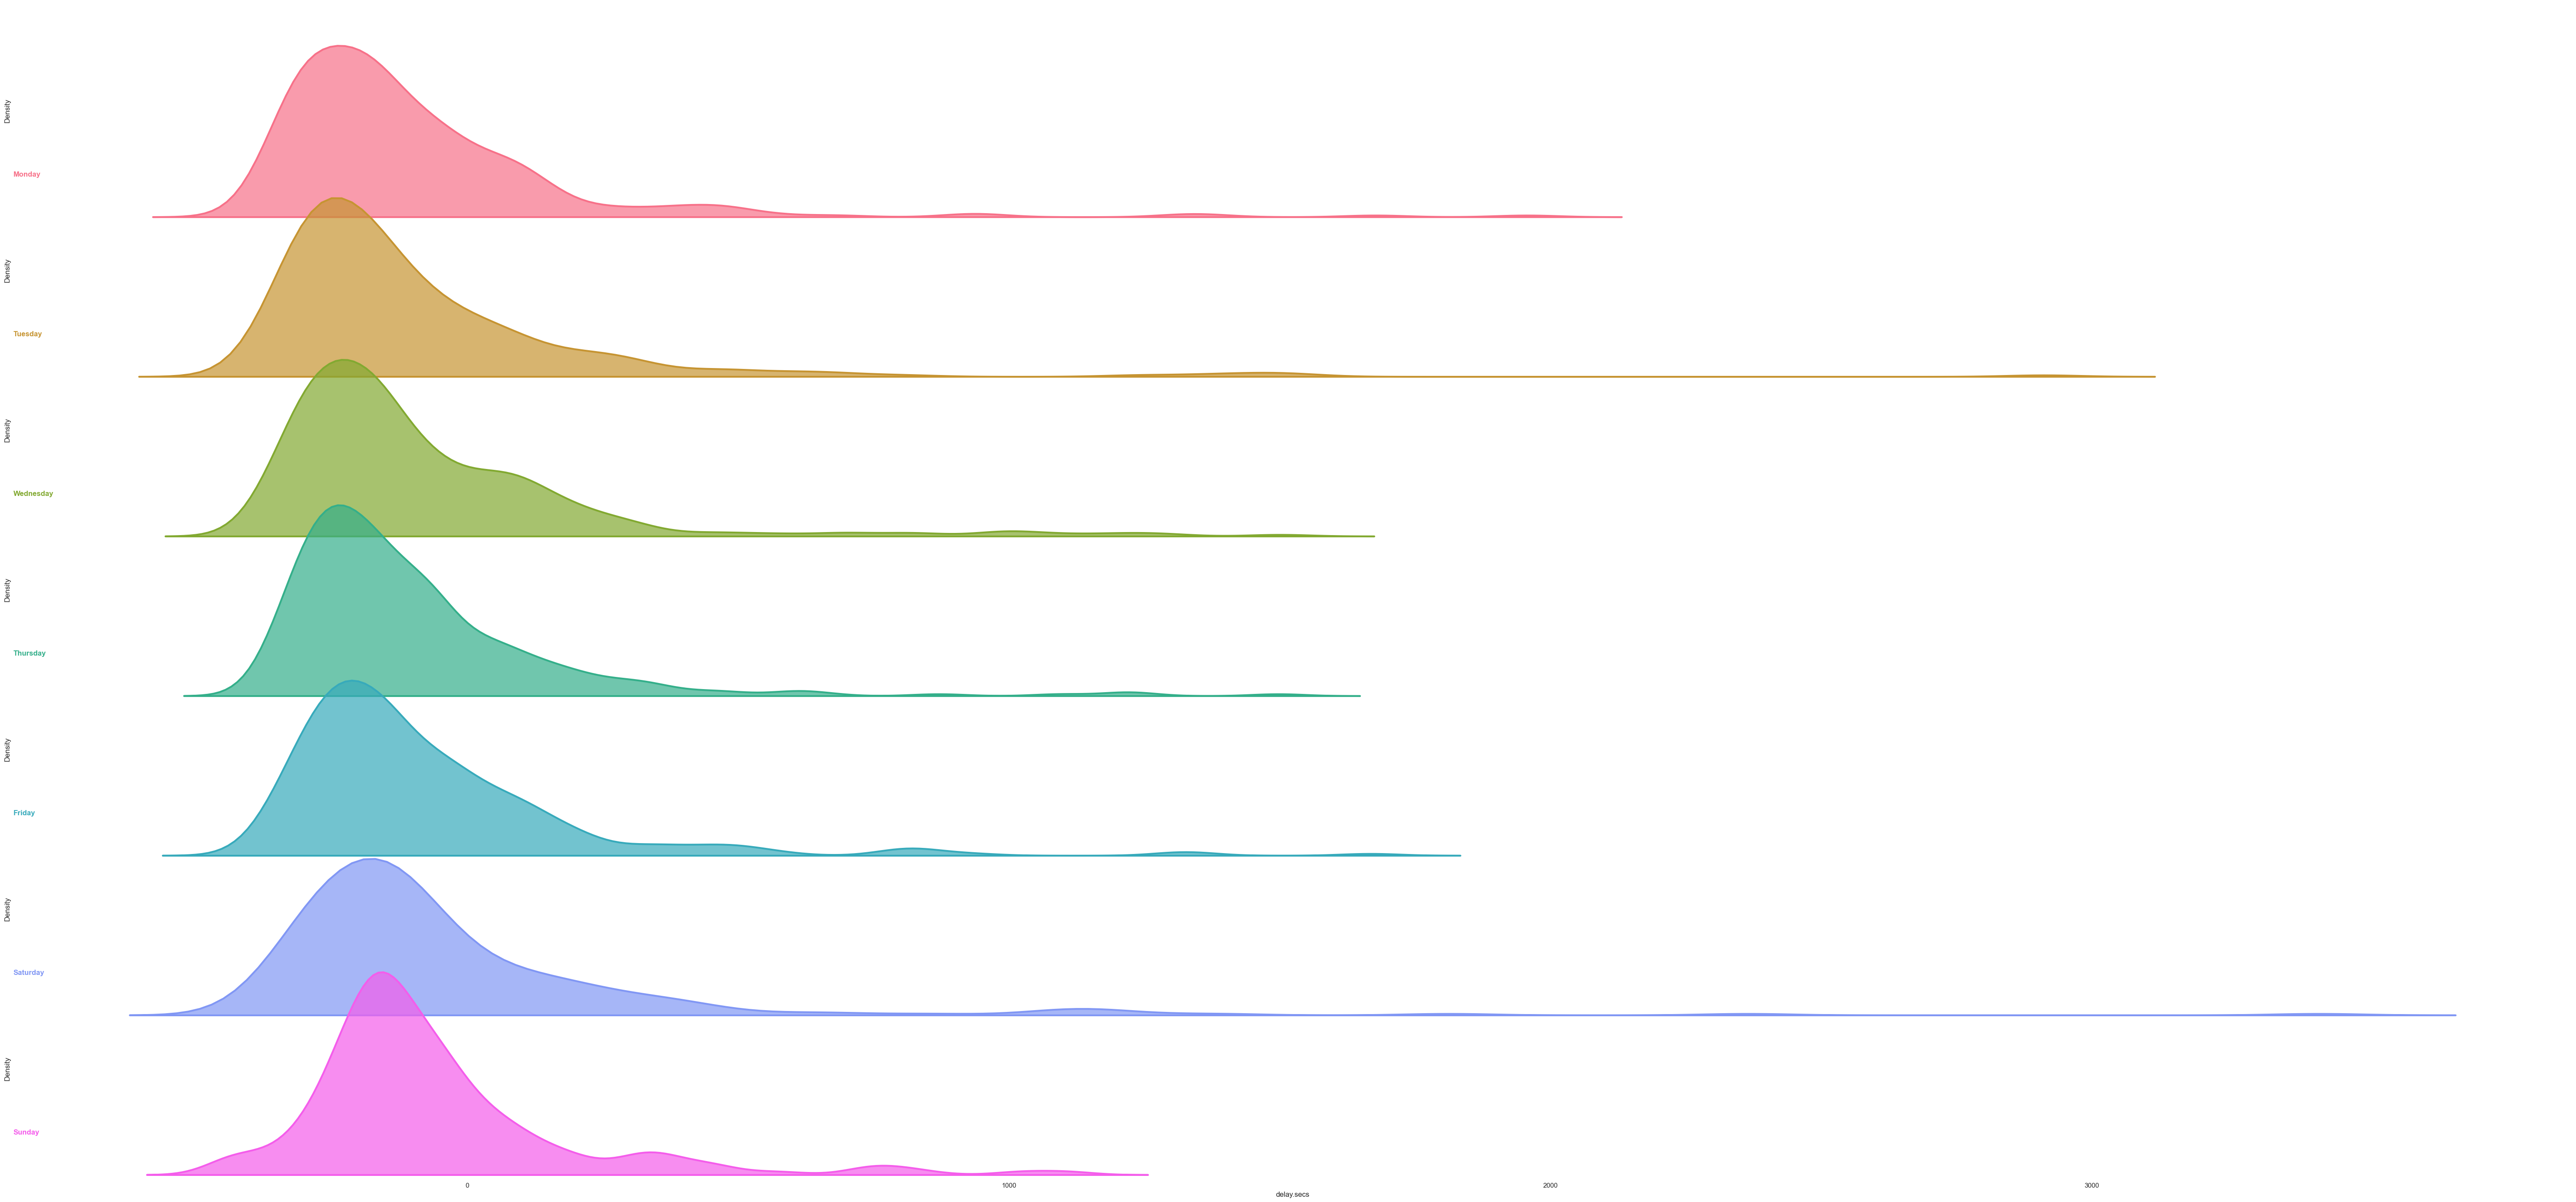

In [4]:
# 山脊图，根据周几来查看火车的延迟情况。
# 可以看出绝大部分情况下都是提前到的，但是在周二和周六下出现长时间延迟的可能会多一些，但也只是少数情况。
# 周日的演示情况反而会很少。可能是英国这边周日的车次会少很多，加上司机会想要早点回家。

# 定义周几的顺序
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

trainingDataConArr_df['week.day'] = pd.Categorical(trainingDataConArr_df['week.day'], categories=days_order, ordered=True)

sns.set_theme(style="white",rc={"axes.facecolor":(0,0,0,0)})
plt.figure(figsize=(100, 60))
palette = sns.color_palette("husl", len(trainingDataConArr_df['week.day'].unique()))
g = sns.FacetGrid(trainingDataConArr_df, row='week.day', hue='week.day', aspect=15, height=4, palette=palette)
g.map(sns.kdeplot, 'delay.secs', clip_on=False, fill=True, alpha=0.7, lw=3, bw=.2)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

g.map(label, "delay.secs")

g.fig.subplots_adjust(hspace=-.250)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

plt.show()


In [5]:

# 统计 'train.code' 列中不同值的数量
# trainingDataConArr_df['train_code'].nunique()
# unique_train_codes_count_test = testDataConArr_df['train_code'].nunique()

# trainingDataTimings_df.columns#检查列名
# print(trainingDataTimings_df.columns)#检查列名
# congestion_df.columns
# print(trainingDataTimings_df.dtypes)#打印每列的数据类型



In [6]:
# #制作Scatterplot Matrix 散点图矩阵
# sns.set_theme(style="ticks")

# # trainingDataTimings_df = sns.load_dataset("penguins")
# sns.pairplot(trainingDataTimisngs_df, hue="day.week")

In [7]:
# 各种功能函数
#用于将一列的值转换为数值型特征的函数。
def encode_discrete_values(df, column_name):
    # 获取指定列的唯一值，并排序（如果是非数值型数据，将按字典序排序）
    unique_values = sorted(df[column_name].unique())
    # 生成从这些唯一值到 1~n 的映射字典
    value_to_num = {value: i + 1 for i, value in enumerate(unique_values)}
    
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in DataFrame.")
        return None, None
    
    df[column_name + '_encoded'] = df[column_name].map(value_to_num)

    return df, value_to_num


# 用于将周几转换为数值型
def encode_weekdays(df, column_name):
    weekday_to_num = {
        'Monday': 1,
        'Tuesday': 2,
        'Wednesday': 3,
        'Thursday': 4,
        'Friday': 5,
        'Saturday': 6,
        'Sunday': 7,
    }
    
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in DataFrame.")
        return None, None
    
    df[column_name + '_encoded'] = df[column_name].map(weekday_to_num)
    return df, weekday_to_num



# 转换车站
def encode_common_discrete_values(df, columns):
    # 获取两列所有唯一值的并集，并排序
    # unique_values = sorted(set(df[columns[0]].unique()).union(set(df[columns[1]].unique())))
    value_to_num = {
        'LEEDS': 1,
        'NORMNTN':2,
        'WKFLDKG':3,
        'WKFLDWG':4,
        'BNSLY':5,
        'MEADWHL':6,
        'SHEFFLD':7,
    }
    # 生成映射字典
    # value_to_num = {value: i + 1 for i, value in enumerate(unique_values)}
    
    # 对指定的两列进行映射转换
    for column in columns:
        if column not in df.columns:
            print(f"Column '{column}' not found in DataFrame.")
            continue
        df[column + '_encoded'] = df[column].map(value_to_num)
    
    # 返回更新后的 DataFrame 和映射字典
    return df, value_to_num
# df, mapping_dict = encode_common_discrete_values(df, ['column1_name', 'column2_name'])

# 计算时间差值
def calculate_time_difference(df, column1, column2, new_column_name='time_difference'):

    if column1 not in df.columns or column2 not in df.columns:
        raise ValueError(f"One or both of the specified columns '{column1}', '{column2}' do not exist in the DataFrame.")
    
    seconds1 = df[column1].apply(text_to_seconds)
    seconds2 = df[column2].apply(text_to_seconds)
    

    df[new_column_name] = (seconds1 - seconds2)
    
    return df


# 将两列相减
def subtract_columns(df, col1, col2, new_col_name):
    df[new_col_name] = df[col1] - df[col2]
    return df

#给所有等候站做减法
def subtract_columns_all(df, cols1, cols2, new_col_names):
    if not (len(cols1) == len(cols2) == len(new_col_names)):
        raise ValueError("The lists of columns and new column names must have the same length.")
    for col1, col2, new_col_name in zip(cols1, cols2, new_col_names):
        df[new_col_name] = df[col1] - df[col2]

    return df

#将两列取平均值
def add_average_column(df, col1, col2, new_col_name):
    df[new_col_name] = (df[col1] + df[col2]) / 2
    return df

#同时生成五列平均值
def add_average_columns(df, cols1, cols2, new_col_names):
    if not (len(cols1) == len(cols2) == len(new_col_names)):
        raise ValueError("The lists of columns and new column names must have the same length.")
    for col1, col2, new_col_name in zip(cols1, cols2, new_col_names):
        df[new_col_name] = (df[col1] + df[col2]) / 2

    return df


# 查看所有车站组合 已经使用下一个函数实现这个功能了，可以不用
def count_onehot_combinations(df, columns):
    subset = df[columns]
    unique_combinations = subset.drop_duplicates().reset_index(drop=True)
    return unique_combinations


#统计车站组合，同时生成新的列，分类车站组合
def add_combination_column_and_get_combinations(df, columns):

    subset = df[columns]
    unique_combinations = subset.drop_duplicates().reset_index(drop=True).reset_index()
    unique_combinations.rename(columns={'index': 'combination_id'}, inplace=True)
    
    df_combined = df.merge(unique_combinations, on=columns, how='left')

    return df_combined, unique_combinations

#查看车站组合和车号是否有关联
def analyze_relationship(df, category_column, onehot_columns):

    df['onehot_combination'] = df[onehot_columns].apply(lambda x: '_'.join(str(int(v)) for v in x), axis=1)
    
    relationship_summary = df.groupby([category_column, 'onehot_combination']).size().reset_index(name='count')
    
    relationship_summary = relationship_summary.sort_values(by=[category_column, 'count'], ascending=[True, False])
    
    return relationship_summary



# 生成统计表，可以看出车号和路线的关系
def analyze_relationship_with_combinations(df, category_column, onehot_columns):

    unique_combinations = df[onehot_columns].drop_duplicates().reset_index(drop=True)
    unique_combinations['combination_id'] = range(len(unique_combinations))
    # print(unique_combinations)


    
    relationship_summary = df.groupby([category_column, 'combination_id']).size().reset_index(name='count')
    # print(relationship_summary)
    relationship_summary = relationship_summary.merge(unique_combinations, on='combination_id', how='left')
    
    relationship_summary = relationship_summary.sort_values(by=[category_column, 'count'], ascending=[True, False])
    
    return relationship_summary


#查看列名，但是每次换行
def print_column_names_new_line(df):
    # 遍历列名并打印每个列名
    for column in df.columns:
        print(f'\'{column}\',')
# print_column_names_new_line(trainmatrix)

#PCA方法
def pca_reduce_dimension(df, target_column=None, variance_threshold=0.95):

    if target_column:
        features = df.drop(target_column, axis=1)
        target = df[target_column]
    else:
        features = df
    

    features_standardized = StandardScaler().fit_transform(features)
    

    pca = PCA(n_components=variance_threshold)
    principal_components = pca.fit_transform(features_standardized)
    
    columns = [f'Principal Component {i+1}' for i in range(principal_components.shape[1])]
    df_pca = pd.DataFrame(data=principal_components, columns=columns)
    
    if target_column:
        df_pca[target_column] = target.reset_index(drop=True)

    return df_pca





In [8]:
# 对于小站的处理：先使用0和1代表是否经过这一站（存在性编码），然后使用平均值代表这些站的总平均延误（聚合）
def datapreprcession(targetdatatimings = trainingDataTimings_df,dataconarr= trainingDataConArr_df,historicalcon=congestion_df):

    #先删除第一列多出来的unmaned列
    matrixdata =drop_first_column(targetdatatimings)
    dataconarr = drop_first_column(dataconarr)
    historicalcon = drop_first_column(historicalcon)
    #重置index列
    dataconarr = dataconarr.reset_index()
    #合并表格
    matrixdata = matrixdata.merge(dataconarr, left_on='id', right_on='index', how='left').drop('index',axis=1)
    #合并历史延误
    matrixdata = matrixdata.merge(historicalcon,left_on=['week.day', 'hour'],right_on=['Day','Hour'],how='left')
    #删除一列重复的列
    matrixdata = matrixdata.drop(['day.week','week.day','hour','train_code','arrival.to_y'],axis=1)
    # 将一列的值转换为数值型特征
    matrixdata, traincode_to_num = encode_discrete_values(matrixdata,column_name='train.code')
    # print(traincode_to_num)
    # 按顺序转换周几为数值型特征
    matrixdata, day_to_num = encode_weekdays(matrixdata,column_name='Day')
    # 将车站转换为数值型特征
    matrixdata,station_to_num=encode_common_discrete_values(matrixdata,['departure.from','arrival.to_x'])
    # print(station_to_num)
    # 计算时间差值
    matrixdata = calculate_time_difference(matrixdata,column1='departure.time',column2='departure.schedule',new_column_name='departure.delay')
    matrixdata = calculate_time_difference(matrixdata,column1='arrival.time_x',column2='arrival.schedule_x',new_column_name='arrival.delay')
    return matrixdata
#应用预处理，得到目标可以训练的数据
# trainmatrix = datapreprcession(targetdatatimings=trainingDataTimings_df,dataconarr=trainingDataConArr_df,historicalcon=congestion_df)
# testmatrix = datapreprcession(targetdatatimings=testDataTimings_df,dataconarr=testDataConArr_df,historicalcon=congestion_df)



In [9]:
# print(trainmatrix['departure.from'].unique())
# print(trainmatrix['arrival.to_x'].unique())
# print(trainmatrix.columns)
# print(trainmatrix.head(10))
# trainmatrix.to_csv('trainmatrix.csv',index=False)

In [10]:

#制作二元变量列的柱状统计图，未使用
def plot_bar_for_binary_columns(df, target_columns):
    sns.set_style("whitegrid")
    
    num_cols = len(target_columns)
    if num_cols == 1:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
        axes = [axes]
    else:
        fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(6, 4 * num_cols))
    
    for i, col in enumerate(target_columns):
        count_data = df[col].value_counts().sort_index()
        sns.barplot(x=count_data.index, y=count_data.values, ax=axes[i], palette="viridis")
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_ylabel('Count')
        axes[i].set_xlabel(col)
    
    plt.tight_layout()
    plt.show()

#二元变量列的柱状统计图，带上他们的统计个数
def plot_bar_for_binary_columns_with_counts(df, target_columns):

    sns.set_style("whitegrid")
    

    num_cols = len(target_columns)
    if num_cols == 1:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
        axes = [axes]
    else:
        fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(6, 4 * num_cols))
    
    for i, col in enumerate(target_columns):

        count_data = df[col].value_counts().sort_index()

        ax = sns.barplot(x=count_data.index, y=count_data.values, ax=axes[i], palette="viridis")
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_ylabel('Count')
        axes[i].set_xlabel(col)


        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                        textcoords='offset points')

    plt.tight_layout()
    plt.show()



#分类列和目标列的分布关系 小提琴图
def plot_violin_by_group(df, group_column, target_column):

    plt.figure(figsize=(10, 6))
    sns.violinplot(x=group_column, y=target_column, data=df)
    plt.title(f'Distribution of {target_column} by {group_column}')
    plt.xlabel(group_column)
    plt.ylabel(target_column)
    plt.show()



# 分类列和目标列的分布关系 密度图
def plot_density_by_group(df, group_column, target_column):
    plt.figure(figsize=(10, 6))
    
    # 为每个分组绘制密度图
    unique_groups = df[group_column].unique()
    for group in unique_groups:
        subset = df[df[group_column] == group]
        sns.kdeplot(subset[target_column], label=f'{group}', shade=True)
    
    plt.title(f'Density Distribution of {target_column} by {group_column}')
    plt.xlabel(target_column)
    plt.ylabel('Density')
    plt.legend(title=group_column)
    plt.show()


#分类列和目标列的分布关系 柱状图
def plot_histograms_by_group(df, group_column, value_column):

    unique_groups = df[group_column].unique()
    

    n_groups = len(unique_groups)
    n_rows = (n_groups // 2) + (n_groups % 2)
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(12, 6 * n_rows), constrained_layout=True)

    if n_groups > 2:
        axes = axes.flatten()
    else:
        axes = axes.reshape(-1) 
    

    for i, group in enumerate(unique_groups):
        ax = axes[i]
        subset = df[df[group_column] == group][value_column]
        sns.histplot(subset, ax=ax, kde=False, binwidth=20)#binwidth 调整柱子宽度 或者bin设置多少个柱子
        ax.set_title(f'{value_column} distribution in {group}')
        ax.set_xlabel(value_column)
        ax.set_ylabel('Frequency')
    

    if n_groups % 2 != 0:
        axes[-1].axis('off')

    plt.show()



#绘制delayNotts的柱状分布
def plot_bar_for_one_var(df,col):

    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))  
    sns.histplot(df[col], bins=50, kde=False, color='skyblue')  # bins指定直方图的柱数，kde为是否绘制核密度估计

    plt.title(f'Distribution of {col}')  
    plt.xlabel('Delay (Notts)')  
    plt.ylabel('Frequency')  
    plt.show()
    return 0


#根据分类列观察目标变量分布，箱线图或者小提琴图
def plot_distribution(data, category_col, target_col, plot_type="boxplot"):

    plt.figure(figsize=(10, 6)) 
    if plot_type == "boxplot":
        sns.boxplot(x=category_col, y=target_col, data=data)
    elif plot_type == "violinplot":
        sns.violinplot(x=category_col, y=target_col, data=data)
    else:
        raise ValueError("plot_type must be 'boxplot' or 'violinplot'")
    
    plt.title(f'Distribution of {target_col} by {category_col}') 
    plt.xticks(rotation=45) 
    plt.show()


# 画热力图，准确来说是层次聚合热力图
def plot_heatmap(df, cols):
    corr = df[cols].corr()
    f, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(corr, annot=False, ax=ax, cmap='coolwarm', fmt='.2f',
                linewidths=.5, cbar_kws={"shrink": .5})#annot 用于控制是否显示数字在每个格子上
    ax.tick_params(axis='y', labelsize=10)
    plt.tight_layout()
    plt.show()


#层次聚合热力图
def plot_clustermap(df,cols):
    corr = df[cols].corr()
    #使用0填充nan，这样才能使用clustermap
    corr_filled = corr.fillna(0)
    sns.clustermap(corr_filled, cmap='coolwarm', linewidths=.5, annot=False,figsize=(9, 6))
    plt.show()
    
#画pairplot,生成起来很耗费时间
def generate_pairplot(df, columns):
    sns.pairplot(df[columns])
    plt.show()
    
#一个分类列，多个数值列，生成小提琴图
def plot_violin_by_category(df, category_column, value_columns):
    plt.figure(figsize=(12, len(value_columns) * 4))
    for i, value_column in enumerate(value_columns, start=1):
        plt.subplot(len(value_columns), 1, i)
        sns.violinplot(x=category_column, y=value_column, data=df)
        plt.title(f'Violin plot of {value_column} by {category_column}')
    plt.tight_layout()
    plt.show()

# 输出所有数值型列的小提琴图
def plot_violin_for_numerical_columns(df):

    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

    fig, axes = plt.subplots(nrows=len(numerical_cols), ncols=1, figsize=(8, len(numerical_cols) * 4))

    if len(numerical_cols) == 1:
        axes = [axes]
    
    for i, col in enumerate(numerical_cols):
        sns.violinplot(x=df[col], ax=axes[i],fill= False)
        axes[i].set_title(col)
        axes[i].set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()


In [11]:
# 考虑到最好还是一行代表一个数据点，关键分只在于不能将conarr表扩散到matrixdata里
def rebuild_matrixdata(df):
    stations_order = [
        'LEEDS', 'NORMNTN', 'WKFLDKG', 'WKFLDWG', 'BNSLY', 'MEADWHL', 'SHEFFLD'
    ]
    
    new_columns = []
    for station in stations_order:
        if station not in ['LEEDS', 'SHEFFLD']:  # 对于LEEDS和SHEFFLD不需要存在性编码
            new_columns.append(f"{station}_presence")
        new_columns.extend([
            f"{station}_dep_time", f"{station}_dep_schedule",
            f"{station}_arr_time", f"{station}_arr_schedule"
        ])
        
    restructured_data_list = []

    for train_id in df['id'].unique():
        train_data = df[df['id'] == train_id]
        row_data = {col: None for col in new_columns}
        
        for station in stations_order:

            if station not in ['LEEDS', 'SHEFFLD']:
                row_data[f"{station}_presence"] = int(station in train_data['departure.from'].values or station in train_data['arrival.to'].values)

            dep_station_data = train_data[train_data['departure.from'] == station]
            if not dep_station_data.empty:
                row_data[f"{station}_dep_time"] = dep_station_data.iloc[0]['departure.time']
                row_data[f"{station}_dep_schedule"] = dep_station_data.iloc[0]['departure.schedule']
            
            arr_station_data = train_data[train_data['arrival.to'] == station]
            if not arr_station_data.empty:
                row_data[f"{station}_arr_time"] = arr_station_data.iloc[0]['arrival.time']
                row_data[f"{station}_arr_schedule"] = arr_station_data.iloc[0]['arrival.schedule']
                
        restructured_data_list.append(row_data)
    
    restructured_data = pd.DataFrame(restructured_data_list)
    restructured_data['id'] = df['id'].unique()
    restructured_data.set_index('id', inplace=True)

    return restructured_data

# 用于将rebuild后的车站情况使用读秒函数将其变为秒
def calculate_delays_and_stays(df):

    for index, row in df.iterrows():
        for col in df.columns:
            if '_dep_time' in col or '_arr_time' in col:
                station = col.split('_')[0]
                time_type = 'dep' if 'dep' in col else 'arr'  # 确定是出发时间还是到达时间

                
                actual_col = f'{station}_{time_type}_time'
                schedule_col = f'{station}_{time_type}_schedule'
                
                # 计算延误时间
                if pd.notna(row[actual_col]) and pd.notna(row[schedule_col]):
                    actual_seconds = text_to_seconds(row[actual_col])
                    schedule_seconds = text_to_seconds(row[schedule_col])
                    df.at[index, f'{station}_{time_type}_delay'] = actual_seconds - schedule_seconds

            # 对于中间站，计算停留时间和计划停留时间
            if '_dep_time' in col and station != 'LEEDS' and station != 'SHEFFLD':
                arr_col = f'{station}_arr_time'
                dep_col = f'{station}_dep_time'
                arr_schedule_col = f'{station}_arr_schedule'
                dep_schedule_col = f'{station}_dep_schedule'

                # 计算实际停留时间和计划停留时间，假设时间和计划时间都存在
                if pd.notna(row[arr_col]) and pd.notna(row[dep_col]) and pd.notna(row[arr_schedule_col]) and pd.notna(row[dep_schedule_col]):
                    arr_seconds = text_to_seconds(row[arr_col])
                    dep_seconds = text_to_seconds(row[dep_col])
                    arr_schedule_seconds = text_to_seconds(row[arr_schedule_col])
                    dep_schedule_seconds = text_to_seconds(row[dep_schedule_col])
                    
                    df.at[index, f'{station}_stay'] = dep_seconds - arr_seconds
                    df.at[index, f'{station}_scheduled_stay'] = dep_schedule_seconds - arr_schedule_seconds

    return df


#基于rebuild_matrixdata函数的新预处理步骤
def datapreprcession2(targetdatatimings = trainingDataTimings_df,dataconarr= trainingDataConArr_df,historicalcon=congestion_df):
    #等后续把之前写的内容全部放到这里来
    #先先出第一列多出来的unmaned列
    datatimings =drop_first_column(targetdatatimings)
    # print(datatimings.head())
    dataconarr = drop_first_column(dataconarr)
    historicalcon = drop_first_column(historicalcon)
    #重置index列
    dataconarr = dataconarr.reset_index()

    #关键两步
    # 重建特征集，每一行代表一辆火车
    matrixdata =rebuild_matrixdata(datatimings)
    #统计delay和stay等特征工程
    matrixdata = calculate_delays_and_stays(matrixdata)

    #合并表格
    matrixdata = matrixdata.merge(dataconarr, left_on='id', right_on='index', how='left').drop('index',axis=1)
    #合并历史延误
    matrixdata = matrixdata.merge(historicalcon,left_on=['week.day', 'hour'],right_on=['Day','Hour'],how='left')
    #删除重复的几列,不删除也可以，等到最后直接从其中提取
    matrixdata = matrixdata.drop(['week.day','hour'],axis=1)
    # 将train.code转换为数值型特征
    # matrixdata, traincode_to_num = encode_discrete_values(matrixdata,column_name='train_code')
    # 另一种将train.code转换为数值型特征的办法：uniques是唯一真值对照表
    codes, uniques = pd.factorize(matrixdata['train_code'])
    matrixdata['train_code.code'] = codes
    #将Day也转换为数值型特征
    days, uniques2 = pd.factorize(matrixdata['Day'])
    matrixdata['Day.code'] = days
    # 将周几转换为onehot特征
    matrixdata = pd.get_dummies(matrixdata, columns=['Day'])
    #将congestion的值取一个平均
    matrixdata = add_average_columns(matrixdata,
                                     cols1=['Leeds.trains_x', 'Leeds.av.delay_x',
       'Sheffield.trains_x', 'Sheffield.av.delay_x', 'Nottingham.trains_x',
       'Nottingham.av.delay_x'],
       cols2=['Leeds.trains_y', 'Leeds.av.delay_y', 'Sheffield.trains_y',
       'Sheffield.av.delay_y', 'Nottingham.trains_y', 'Nottingham.av.delay_y'],
       new_col_names=['Leeds.trains', 'Leeds.av.delay',
       'Sheffield.trains', 'Sheffield.av.delay', 'Nottingham.trains',
       'Nottingham.av.delay'])
    # 统计小站组合，并生成分类列
    matrixdata, unique_combinations = add_combination_column_and_get_combinations(matrixdata,['NORMNTN_presence','WKFLDKG_presence','WKFLDWG_presence','BNSLY_presence','MEADWHL_presence'])
    # print(unique_combinations)
    #将小站的延迟取一个平均
    matrixdata['station_ave'] = matrixdata[['WKFLDKG_dep_delay', 'WKFLDKG_arr_delay', 'BNSLY_dep_delay', 
            'BNSLY_arr_delay','MEADWHL_dep_delay', 
       'MEADWHL_arr_delay', 'NORMNTN_dep_delay',
       'NORMNTN_arr_delay',
       'WKFLDWG_dep_delay', 
       'WKFLDWG_arr_delay']].mean(axis=1,skipna=True)
    
    # #将车站的等待时间做一个减法
    matrixdata = subtract_columns_all(matrixdata,
                                      cols1=['WKFLDKG_stay',
       'BNSLY_stay', 'MEADWHL_stay', 
       'NORMNTN_stay', 'WKFLDWG_stay'],
       cols2=[
       'WKFLDKG_scheduled_stay','BNSLY_scheduled_stay','MEADWHL_scheduled_stay',
       'NORMNTN_scheduled_stay','WKFLDWG_scheduled_stay'],
       new_col_names=['WKFLDKG_stay_subtract',
       'BNSLY_stay_subtract', 'MEADWHL_stay_subtract', 
       'NORMNTN_stay_subtract', 'WKFLDWG_stay_subtract'])
    
    #将congestion也做一个减法，借鉴老师的建议
    matrixdata = subtract_columns_all(matrixdata,
                                     cols1=['Leeds.trains_x', 'Leeds.av.delay_x',
       'Sheffield.trains_x', 'Sheffield.av.delay_x', 'Nottingham.trains_x',
       'Nottingham.av.delay_x'],
       cols2=['Leeds.trains_y', 'Leeds.av.delay_y', 'Sheffield.trains_y',
       'Sheffield.av.delay_y', 'Nottingham.trains_y', 'Nottingham.av.delay_y'],
       new_col_names=['Leeds.trains_sub', 'Leeds.av.delay_sub',
       'Sheffield.trains_sub', 'Sheffield.av.delay_sub', 'Nottingham.trains_sub',
       'Nottingham.av.delay_sub'])
    
    #去掉一些并没有用的列
    matrixdata = matrixdata.drop(['arrival.to','LEEDS_arr_time','LEEDS_arr_schedule','SHEFFLD_dep_time','SHEFFLD_dep_schedule'],axis=1)
    
    return matrixdata

In [20]:
#  下面是推荐的pipeline的代码框架
def process_features(df):
    #TBD 之后还会修改成只选取一部分列作为特征集，而不是使用drop
    '''
    # 没有修改数值的版本
    df = df[['WKFLDKG_presence','NORMNTN_presence','WKFLDWG_presence','BNSLY_presence','MEADWHL_presence',
            'LEEDS_dep_delay', 'WKFLDKG_dep_delay', 'WKFLDKG_stay',
       'WKFLDKG_scheduled_stay', 'WKFLDKG_arr_delay', 'BNSLY_dep_delay',
       'BNSLY_stay', 'BNSLY_scheduled_stay', 'BNSLY_arr_delay',
       'MEADWHL_dep_delay', 'MEADWHL_stay', 'MEADWHL_scheduled_stay',
       'MEADWHL_arr_delay', 'SHEFFLD_arr_delay', 'NORMNTN_dep_delay',
       'NORMNTN_stay', 'NORMNTN_scheduled_stay', 'NORMNTN_arr_delay',
       'WKFLDWG_dep_delay', 'WKFLDWG_stay', 'WKFLDWG_scheduled_stay',
       'WKFLDWG_arr_delay', 'Leeds.trains_x', 'Leeds.av.delay_x',
       'Sheffield.trains_x', 'Sheffield.av.delay_x', 'Nottingham.trains_x',
       'Nottingham.av.delay_x', 'delay.secs', 'Hour',
       'Leeds.trains_y', 'Leeds.av.delay_y', 'Sheffield.trains_y',
       'Sheffield.av.delay_y', 'Nottingham.trains_y', 'Nottingham.av.delay_y',
       'train_code.code', 'Day_Friday', 'Day_Monday', 'Day_Saturday',
       'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday']]
    '''
 
    # 将congestion变为平均值的版本 #得分33000
    # df = df[['NORMNTN_presence','WKFLDKG_presence','WKFLDWG_presence','BNSLY_presence','MEADWHL_presence',
             
    #         'LEEDS_dep_delay', 'WKFLDKG_dep_delay', 'WKFLDKG_stay',
    #    'WKFLDKG_scheduled_stay', 'WKFLDKG_arr_delay', 'BNSLY_dep_delay',
    #    'BNSLY_stay', 'BNSLY_scheduled_stay', 'BNSLY_arr_delay',
    #    'MEADWHL_dep_delay', 'MEADWHL_stay', 'MEADWHL_scheduled_stay',
    #    'MEADWHL_arr_delay', 'SHEFFLD_arr_delay', 'NORMNTN_dep_delay',
    #    'NORMNTN_stay', 'NORMNTN_scheduled_stay', 'NORMNTN_arr_delay',
    #    'WKFLDWG_dep_delay', 'WKFLDWG_stay', 'WKFLDWG_scheduled_stay',
    #    'WKFLDWG_arr_delay',  
    #    'delay.secs', 
    #    'Hour',
    #    'Leeds.trains', 'Leeds.av.delay',
    #    'Sheffield.trains', 'Sheffield.av.delay', 'Nottingham.trains',
    #    'Nottingham.av.delay',
    #    'train_code.code', 'Day.code']]
    
    #得分33200/29000
    # df = df[['NORMNTN_presence','WKFLDKG_presence','WKFLDWG_presence','BNSLY_presence','MEADWHL_presence',
    #         'LEEDS_dep_delay',  'WKFLDKG_stay',
    #    'WKFLDKG_scheduled_stay',
    #    'BNSLY_stay', 'BNSLY_scheduled_stay', 'MEADWHL_stay', 'MEADWHL_scheduled_stay', 'SHEFFLD_arr_delay',
    #    'station_ave',
    #    'NORMNTN_stay', 'NORMNTN_scheduled_stay', 'WKFLDWG_stay', 'WKFLDWG_scheduled_stay',
    #     'delay.secs', 'Hour',
    #    'Leeds.trains', 'Leeds.av.delay',
    #    'Sheffield.trains', 'Sheffield.av.delay', 'Nottingham.trains',
    #    'Nottingham.av.delay',
    #    'train_code.code', 'Day.code']]

    #     #朴素得分29576.1508
    #     df = df[[
    #         'delay.secs','Hour',
    #                         'Day_Friday',
    #         'Day_Monday',
    #         'Day_Saturday',
    #         'Day_Sunday',
    #         'Day_Thursday',
    #         'Day_Tuesday',
    #         'Day_Wednesday',
    #         # 'Leeds.trains',
    # # 'Leeds.av.delay',
    # # 'Sheffield.trains',
    # # 'Sheffield.av.delay',
    # # 'Nottingham.trains',
    # # 'Nottingham.av.delay',# 带上congestion的数值比不带还要差
    #         'SHEFFLD_arr_delay',
    #         'LEEDS_dep_delay'        
    #     ]]

    
   #得分29000 使用小站平均延迟，小站停站计划与实际差值
    df = df[['NORMNTN_presence','WKFLDKG_presence','WKFLDWG_presence','BNSLY_presence','MEADWHL_presence',
            'LEEDS_dep_delay',  'SHEFFLD_arr_delay',
       'station_ave',
       'WKFLDKG_stay_subtract',
       'BNSLY_stay_subtract', 'MEADWHL_stay_subtract', 
       'NORMNTN_stay_subtract', 'WKFLDWG_stay_subtract',
        'delay.secs', 'Hour',
       'Leeds.trains', 'Leeds.av.delay',
       'Sheffield.trains', 'Sheffield.av.delay', 'Nottingham.trains',
       'Nottingham.av.delay',
       'train_code.code', 'Day.code']]
    
 #  # 
    # df = df[['NORMNTN_presence','WKFLDKG_presence','WKFLDWG_presence','BNSLY_presence','MEADWHL_presence',
    #         'LEEDS_dep_delay',  'SHEFFLD_arr_delay',
    #    'station_ave',
    #     'delay.secs', 'Hour',
    #    'Leeds.trains', 'Leeds.av.delay',
    #    'Sheffield.trains', 'Sheffield.av.delay', 'Nottingham.trains',
    #    'Nottingham.av.delay',
    #    'train_code.code', 'Day.code']]
   

       
    # #将车站停留时间变为相减的插值的版本 #得分34000
    # df = df[['WKFLDKG_presence','NORMNTN_presence','WKFLDWG_presence','BNSLY_presence','MEADWHL_presence',
    #         'LEEDS_dep_delay', 'WKFLDKG_dep_delay', 'WKFLDKG_arr_delay', 'BNSLY_dep_delay', 
    #         'BNSLY_arr_delay','MEADWHL_dep_delay', 
    #    'MEADWHL_arr_delay', 'SHEFFLD_arr_delay', 'NORMNTN_dep_delay',
    #    'NORMNTN_arr_delay',
    #    'WKFLDWG_dep_delay', 
    #    'WKFLDWG_arr_delay', 'WKFLDKG_stay_subtract',
    #    'BNSLY_stay_subtract', 'MEADWHL_stay_subtract', 
    #    'NORMNTN_stay_subtract', 'WKFLDWG_stay_subtract',
    #     'delay.secs', 'Hour',
    #    'Leeds.trains', 'Leeds.av.delay',
    #    'Sheffield.trains', 'Sheffield.av.delay', 'Nottingham.trains',
    #    'Nottingham.av.delay',
    #    'train_code.code', 'Day_Friday', 'Day_Monday', 'Day_Saturday',
    #    'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday']] 
    
    # df = df.drop(['train.code', 'departure.from', 'departure.time', 'departure.schedule',
    #    'arrival.to_x', 'arrival.time_x','arrival.schedule_x','arrival.time_y', 'arrival.schedule_y','Day'],axis=1)
    return df


# 获取特征和目标变量
def get_features_and_target(df, target_column_name):
    X = df.drop(target_column_name, axis=1)
    y = df[target_column_name]
    return X, y

# 创建pipeline
def create_pipeline():
    pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('regressor', XGBRegressor(objective='reg:squarederror')) 
    ])
    return pipeline

# 设置网格搜索的参数
params = {
    'regressor__max_depth': [2,3,5],
    'regressor__n_estimators': [50,90,100,110],
    'regressor__learning_rate': [0.1,0.15,0.2]
}

# 使用pycaret库函数统一进行训练
def pycaret_regression_framework(df, target_column):

    # 设置回归实验
    # log_experiment=True可以用来记录实验，但在这个例子中我们将其省略
    # silent=True禁止PyCaret在setup阶段交互式地询问数据类型
    reg_experiment = setup(data=df, target=target_column,log_experiment=True)
    
    # 比较不同模型的性能
    best_model = compare_models(sort='MSE')

        
    # 对选定的模型进行超参数调优
    best_model = tune_model(best_model, optimize='MSE')
        
    # 打印最佳模型
    print("Best Model: ", best_model)

    return best_model

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

def train_lasso_model(df, target_column, alpha=1.0):
    """
    Train a Lasso regression model.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the features and target.
    target_column (str): The name of the column in df which is the target variable.
    alpha (float): The regularization strength; must be a positive float. Larger values specify stronger regularization.

    Returns:
    Lasso: The trained Lasso model.
    """
    
    # Split the data into features and target
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    # Initialize the Lasso regression model
    lasso = Lasso(alpha=alpha)
    
    # Fit the model to the training data
    lasso.fit(X_train, y_train)
    
    # Here you could return the trained model and/or its evaluation on the test set
    return lasso

# Example usage:
# trained_model = train_lasso_model(df, 'target_column_name')


# 主函数
def main():
    # 加载数据
    # df = load_data('path/to/your/dataset.csv')

    #声明全局变量
    global trainmatrix
    global testmatrix
    global featurematrix

    #执行预处理
    # trainmatrix = datapreprcession(targetdatatimings=trainingDataTimings_df,dataconarr=trainingDataConArr_df,historicalcon=congestion_df)
    trainmatrix = datapreprcession2(targetdatatimings=trainingDataTimings_df,dataconarr=trainingDataConArr_df,historicalcon=congestion_df)
    testmatrix = datapreprcession2(targetdatatimings=testDataTimings_df,dataconarr=testDataConArr_df,historicalcon=congestion_df)    

    #特殊处理trainmatrix,
    trainmatrix = trainmatrix[~trainmatrix['combination_id'].isin(['3','5','8','9'])]


    # 先删去无法使用的特征列
    featurematrix = process_features(trainmatrix)
    featurematrix_test = process_features(testmatrix)
    # print(trainmatrix.columns)
    
    # 执行PCA方法 暂时无法使用
    # featurematrix = pca_reduce_dimension(featurematrix,target_column='delay.secs',variance_threshold=0.95)
    
    # 获取特征和目标变量
    X, y = get_features_and_target(featurematrix, 'delay.secs')
    X_test,y_test = get_features_and_target(featurematrix_test,'delay.secs')

    # # 创建pipeline
    # pipeline = create_pipeline()
    
    # # 创建GridSearchCV对象
    # grid_search = GridSearchCV(pipeline, param_grid=params, cv=10, scoring='neg_mean_squared_error', verbose=1)
    
    # # # 执行网格搜索
    # grid_search.fit(X, y)
    
    # # # 打印最佳参数和最佳分数（MSE）
    # print(f"Best parameters: {grid_search.best_params_}")
    # print(f"Best cross-validation score (MSE): {-grid_search.best_score_}")

    # # 使用最佳模型进行预测
    # y_pred = grid_search.predict(X_test)


    #使用pycaret
    best_model = pycaret_regression_framework(featurematrix,'delay.secs')
    #预测结果
    predictions = predict_model(best_model, data=X_test)
    predictions.to_csv('predictions v5.0.csv',index=False)


    # # （可选）如果你有测试集的目标变量，评估模型
    # if 'y_test' in locals():
    #     mse = mean_squared_error(y_test, y_pred)
    #     print(f"Test MSE: {mse}")
    
    # 返回预测结果
    # return 0#y_pred

if __name__ == "__main__":
    predicted_values = main()
    

,Description,Value
0,Session id,200
1,Target,delay.secs
2,Target type,Regression
3,Original data shape,"(1859, 23)"
4,Transformed data shape,"(1859, 23)"
5,Transformed train set shape,"(1301, 23)"
6,Transformed test set shape,"(558, 23)"
7,Numeric features,22
8,Rows with missing values,100.0%
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,113.8764,28158.3609,164.5536,0.6360,0.9899,1.7003,0.0090
et,Extra Trees Regressor,111.8646,28182.3182,164.7744,0.6379,0.9819,1.6109,0.1400
lasso,Lasso Regression,114.0311,28324.1330,165.1959,0.6338,1.0241,1.6844,0.0110
llar,Lasso Least Angle Regression,114.0314,28324.2796,165.1964,0.6338,1.0241,1.6844,0.0100
en,Elastic Net,114.0329,28338.3352,165.2227,0.6338,1.0100,1.6821,0.0220
br,Bayesian Ridge,113.9925,28361.2717,165.1992,0.6338,0.9862,1.6917,0.0110
ridge,Ridge Regression,114.1799,28366.0787,165.3811,0.6329,1.0195,1.6751,0.0170
lr,Linear Regression,114.2881,28391.2481,165.4747,0.6325,1.0203,1.6769,0.0150
lar,Least Angle Regression,116.6148,29131.2119,167.9145,0.6225,1.0543,1.7321,0.0100
huber,Huber Regressor,111.9098,29231.0767,167.5941,0.6248,0.9959,1.7735,0.0140


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,124.1254,41629.6930,204.0336,0.5426,0.9296,0.6974
1,98.9969,17308.2935,131.5610,0.7607,0.9760,0.8499
2,110.7582,40436.4332,201.0881,0.4251,1.0038,0.8034
3,150.3374,51152.9220,226.1701,0.6786,1.1525,1.4450
4,99.1856,21303.9561,145.9587,0.5659,0.9788,2.1083
5,111.6906,19446.9961,139.4525,0.6906,1.1403,2.1752
6,108.8846,23685.9274,153.9023,0.4218,0.8988,1.8165
7,125.3505,28375.8642,168.4514,0.7780,1.0253,1.9150
8,102.1605,17166.1591,131.0197,0.7267,1.1786,3.0427


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Best Model:  OrthogonalMatchingPursuit()


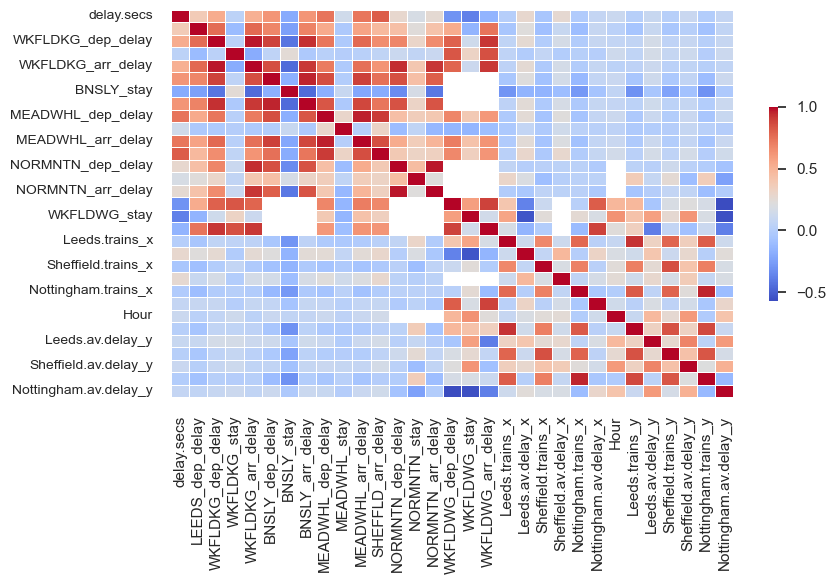

'LEEDS_dep_time',
'LEEDS_dep_schedule',
'NORMNTN_presence',
'NORMNTN_dep_time',
'NORMNTN_dep_schedule',
'NORMNTN_arr_time',
'NORMNTN_arr_schedule',
'WKFLDKG_presence',
'WKFLDKG_dep_time',
'WKFLDKG_dep_schedule',
'WKFLDKG_arr_time',
'WKFLDKG_arr_schedule',
'WKFLDWG_presence',
'WKFLDWG_dep_time',
'WKFLDWG_dep_schedule',
'WKFLDWG_arr_time',
'WKFLDWG_arr_schedule',
'BNSLY_presence',
'BNSLY_dep_time',
'BNSLY_dep_schedule',
'BNSLY_arr_time',
'BNSLY_arr_schedule',
'MEADWHL_presence',
'MEADWHL_dep_time',
'MEADWHL_dep_schedule',
'MEADWHL_arr_time',
'MEADWHL_arr_schedule',
'SHEFFLD_arr_time',
'SHEFFLD_arr_schedule',
'LEEDS_dep_delay',
'WKFLDKG_dep_delay',
'WKFLDKG_stay',
'WKFLDKG_scheduled_stay',
'WKFLDKG_arr_delay',
'BNSLY_dep_delay',
'BNSLY_stay',
'BNSLY_scheduled_stay',
'BNSLY_arr_delay',
'MEADWHL_dep_delay',
'MEADWHL_stay',
'MEADWHL_scheduled_stay',
'MEADWHL_arr_delay',
'SHEFFLD_arr_delay',
'NORMNTN_dep_delay',
'NORMNTN_stay',
'NORMNTN_scheduled_stay',
'NORMNTN_arr_delay',
'WKFLDWG_dep_delay

In [13]:
# 生成csv文件
# predicted_df = pd.DataFrame(predicted_values,columns=['x'])
# predicted_df.to_csv('trains_group_v5.0.csv',index=False)

#做个热力图，即相关系数图

cols = [ 'delay.secs','LEEDS_dep_delay', 'WKFLDKG_dep_delay', 'WKFLDKG_stay',
        'WKFLDKG_arr_delay', 'BNSLY_dep_delay',
       'BNSLY_stay',  'BNSLY_arr_delay',
       'MEADWHL_dep_delay', 'MEADWHL_stay', 
       'MEADWHL_arr_delay', 'SHEFFLD_arr_delay', 'NORMNTN_dep_delay',
       'NORMNTN_stay',  'NORMNTN_arr_delay',
       'WKFLDWG_dep_delay', 'WKFLDWG_stay',
       'WKFLDWG_arr_delay', 'Leeds.trains_x', 'Leeds.av.delay_x',
       'Sheffield.trains_x', 'Sheffield.av.delay_x', 'Nottingham.trains_x',
       'Nottingham.av.delay_x','Hour',
       'Leeds.trains_y', 'Leeds.av.delay_y', 'Sheffield.trains_y',
       'Sheffield.av.delay_y', 'Nottingham.trains_y', 'Nottingham.av.delay_y']
       
plot_heatmap(trainmatrix,cols)

#成对列的关系
# generate_pairplot(trainmatrix, cols)

# print_column_names_new_line(trainmatrix)
# trainmatrix.info()

In [14]:
# 功能其实已经被替代
# count_onehot_combinations(trainmatrix,['NORMNTN_presence','WKFLDKG_presence','WKFLDWG_presence','BNSLY_presence','MEADWHL_presence'])


# 非常重要的分析：车站组合与班次的关系
train_station_set = analyze_relationship_with_combinations(trainmatrix,category_column='train_code.code',onehot_columns=['NORMNTN_presence','WKFLDKG_presence','WKFLDWG_presence','BNSLY_presence','MEADWHL_presence'])
# print(train_station_set)
# train_station_set.to_csv('train_station_set.csv',index=False)
test_station_set = analyze_relationship_with_combinations(testmatrix,category_column='train_code.code',onehot_columns=['NORMNTN_presence','WKFLDKG_presence','WKFLDWG_presence','BNSLY_presence','MEADWHL_presence'])
# print(test_station_set)
# test_station_set.to_csv('test_station_set.csv',index=False)


# 假设 `df` 是你的DataFrame，`category_col` 是分类变量列名，`onehot_cols` 是one-hot编码列的列表
# 计算关联性
def explore_relationship(df, category_col, onehot_cols):
    # 找到唯一的one-hot编码组合
    # unique_combinations = df[onehot_cols].drop_duplicates()
    unique_combinations = count_onehot_combinations(df,onehot_cols)
    # 对每个组合计算分类变量的分布
    for index, row in unique_combinations.iterrows():
        subset = df[(df[onehot_cols] == row.values).all(axis=1)]
        distribution = subset[category_col].value_counts(normalize=True)
        print(f"Combination {index} distribution:\n{distribution}\n")

# relationship = explore_relationship(trainmatrix, 'train_code.code', ['NORMNTN_presence','WKFLDKG_presence','WKFLDWG_presence','BNSLY_presence','MEADWHL_presence'])


In [15]:
# print(trainmatrix2.columns)
selected_columns = ['LEEDS_dep_delay', 'WKFLDKG_dep_delay', 'WKFLDKG_stay',
       'WKFLDKG_scheduled_stay', 'WKFLDKG_arr_delay', 'BNSLY_dep_delay',
       'BNSLY_stay', 'BNSLY_scheduled_stay', 'BNSLY_arr_delay',
       'MEADWHL_dep_delay', 'MEADWHL_stay', 'MEADWHL_scheduled_stay',
       'MEADWHL_arr_delay', 'SHEFFLD_arr_delay', 'NORMNTN_dep_delay',
       'NORMNTN_stay', 'NORMNTN_scheduled_stay', 'NORMNTN_arr_delay',
       'WKFLDWG_dep_delay', 'WKFLDWG_stay', 'WKFLDWG_scheduled_stay',
       'WKFLDWG_arr_delay']  # Replace with your actual column names
selected_columns2 = ['NORMNTN_presence','WKFLDKG_presence','WKFLDWG_presence','BNSLY_presence','MEADWHL_presence']
# plot_ridge(trainmatrix3, selected_columns)
# plot_violin_for_numerical_columns(trainmatrix3)
# plot_bar_for_binary_columns_with_counts(trainmatrix3,selected_columns2)
# print(trainingDataConArr_df.columns)

# plot_histograms_by_group(trainmatrix,group_column='combination_id',value_column='delay.secs')
# plot_distribution(trainmatrix,category_col='combination_id',target_col='delay.secs',plot_type='boxplot')
# plot_distribution(trainmatrix,category_col='train_code.code',target_col='delay.secs',plot_type='boxplot')

#统计一分类列中的每个类的个数
# print(trainmatrix['combination_id'].value_counts())
# print(testmatrix['combination_id'].value_counts())

In [16]:
#我意识到车站组合真值表只对我自己比较有用，我并不把他放入我的机器学习当中，因为过站的存在性编码更重要。
def create_truth_table(train_df, test_df, onehot_columns):

    
    # Create a unique identifier for the one-hot combinations in both sets
    train_df['combination_id'] = train_df[onehot_columns].apply(lambda x: '_'.join(x.astype(str)), axis=1)
    test_df['combination_id'] = test_df[onehot_columns].apply(lambda x: '_'.join(x.astype(str)), axis=1)
    
    # Find the common combinations
    common_combinations = pd.merge(
        train_df[['combination_id']],
        test_df[['combination_id']],
        on='combination_id',
        how='inner'
    )['combination_id'].unique()
    
    # Create the truth table
    truth_table = train_df[train_df['combination_id'].isin(common_combinations)]
    
    return truth_table

# Usage
# Define the column names for the one-hot encoded features
onehot_columns = ['NORMNTN_presence','WKFLDKG_presence','WKFLDWG_presence','BNSLY_presence','MEADWHL_presence']

# Call the function with the paths to your CSV files
truth_table = create_truth_table(train_station_set,test_station_set, onehot_columns)

# The resulting 'truth_table' DataFrame will contain all rows from the training set
# that have a 'combination_id' present in both the training and testing sets.

# #观察小时和历史延时等数据的小提琴关系，效果很差。
# plot_violin_by_category(trainmatrix,category_column='Hour',value_columns=[
#            'Leeds.trains', 'Leeds.av.delay',
#        'Sheffield.trains', 'Sheffield.av.delay', 'Nottingham.trains',
#        'Nottingham.av.delay',
# ])
#观察小时和现在延误时间的观察，并没有C组那样的观测效果
# plot_distribution(trainmatrix,'Hour','delay.secs','boxplot')


In [17]:
#尝试验证分类列和目标数值列之间的显著差异性
from scipy.stats import f_oneway


df = trainmatrix
# 清理包含NaN值的组
groups = [df[df['Hour'] == hour]['delay.secs'].dropna() for hour in range(7, 21)]

# 只包含非空组的ANOVA
non_empty_groups = [group for group in groups if not group.empty]
if len(non_empty_groups) > 1:  # 需要至少两组进行ANOVA
    f_statistic, p_value = f_oneway(*non_empty_groups)
    print(f"F Statistic: {f_statistic}, p-value: {p_value}")
else:
    print("Not enough non-empty groups for ANOVA")
#F Statistic: 6.573105233571209, p-value: 2.1355187679532672e-12
#如果p值小于显著性水平（如0.05），则表示不同组间存在显著差异，即分类列对目标变量具有显著的分类性。



F Statistic: 6.573105233571209, p-value: 2.1355187679532672e-12


In [18]:
trainmatrix['delay.secs'].describe()

count    1859.000000
mean      -76.760086
std       306.383802
min      -442.000000
25%      -251.000000
50%      -156.000000
75%       -13.000000
max      3419.000000
Name: delay.secs, dtype: float64